In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import preprocessing
import math

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

## Extração dos dados

In [2]:
data = pd.read_excel("Data/dataset.xls", sheet_name='Análise_ML')

In [3]:
data

,Pred_class,probabilidade,status,True_class
0,2,0.079892,approved,0.0
1,2,0.379377,approved,74.0
2,2,0.379377,approved,74.0
3,2,0.420930,approved,74.0
4,2,0.607437,approved,NaN
...,...,...,...,...
638,60,0.543772,revision,NaN
639,60,0.553846,revision,NaN
640,77,0.606065,revision,NaN
641,84,0.561842,revision,NaN


## Analise Exploratória - Item 1

### Dados ausentes

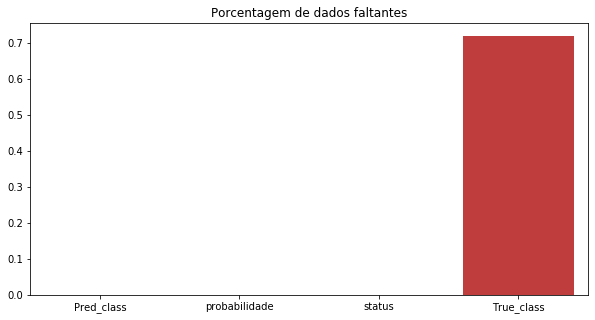

In [4]:
plt.figure(figsize=(10,5))
plt.title("Porcentagem de dados faltantes")
sns.barplot(x=data.isna().sum().keys(), y=data.isna().sum().values/len(data))

In [5]:
not_nan_data = data.copy()
not_nan_data['True_class'] = not_nan_data['True_class'].fillna(value=data['Pred_class']).reset_index(drop=True)
not_nan_data['True_class'] = not_nan_data['True_class'].astype(np.int)

Mais de 70% da True_class não tem informação, ou seja, mais de 70% dos dados não tiveram a classificação de seu valor.

### Distribuição da True e Pred class

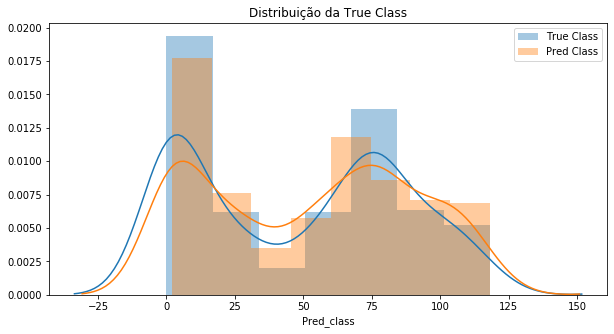

In [6]:
plt.figure(figsize=(10,5))
plt.title("Distribuição da True Class")
sns.distplot(not_nan_data['True_class'], label="_trueclass")
sns.distplot(not_nan_data['Pred_class'], label="_pred")
plt.legend(["True Class", "Pred Class"])
plt.show()

A distribuição indica que há classes com a classificação errada (pred class), pois as distribuições não coincidem. Além disso, é importante destacar o desbalanceamento dos dados na True Class, onde há mais informações entre o intervalo 0-25 do que o intervalo 25-75, por exemplo.

### Distribuição do status da classificação

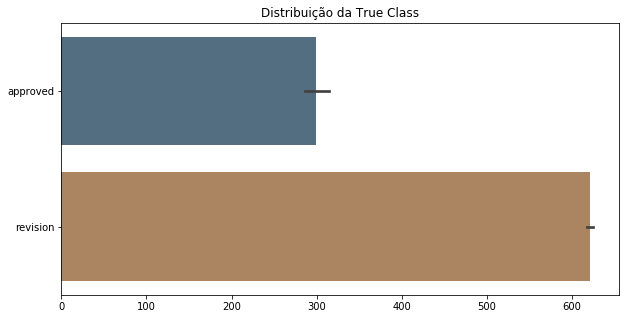

In [7]:
plt.figure(figsize=(10,5))
plt.title("Distribuição da True Class")
sns.barplot(not_nan_data['status'].keys(), not_nan_data['status'].values, saturation=0.3)
plt.show()

Apenas uma parte dos dados estão com status de aprovados, isso é uma informação importante, pois caso haja a necessidade de montar um modelo de classificação, teremos que usar os dados com status de aprovado, para garantir a certeza nos nossos resultados

### Distribuição da probabilidade

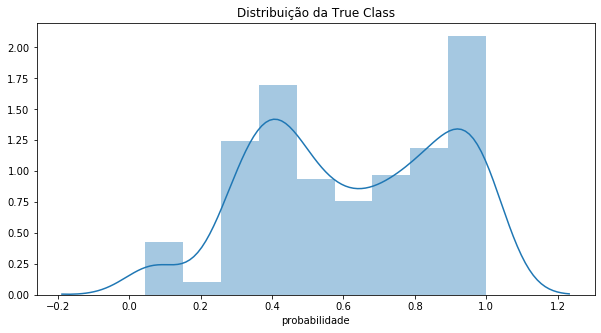

In [8]:
plt.figure(figsize=(10,5))
plt.title("Distribuição da True Class")
sns.distplot(not_nan_data['probabilidade'])
plt.show()

Novamente, temos dados desbalanceados, com dados enviesados para direita (right skew). Há alguns processamentos, como normalização e padronização dos dados, usando funções como sigmoid, log, tanh. Nesse caso, usaremos a normalização seguida pela raiz cubica do quadrado dos dados.

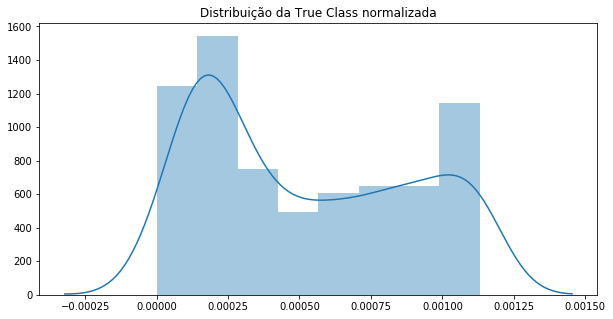

In [9]:
normalized_prob = preprocessing.normalize([not_nan_data['probabilidade']])

plt.figure(figsize=(10,5))
plt.title("Distribuição da True Class normalizada")
sns.distplot((normalized_prob)**2/3)
plt.show()

Percebe-se a diferença, temos algo proximo de uma distribuição uniforme, fator importante para alguns modelos, além de poder trazer melhores resultados. Verificaremos a diferença de score entre os dados processados ou não futuramente

### Correção entre probabilidade e True Class

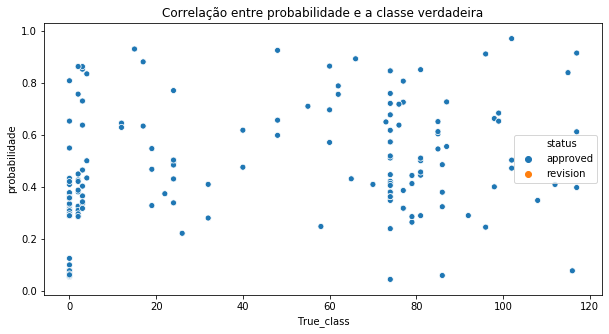

In [10]:
prob = data['probabilidade']
true_class = data['True_class']
plt.figure(figsize=(10,5))
plt.title("Correlação entre probabilidade e a classe verdadeira")
sns.scatterplot(true_class, prob, hue = data['status'])

Visualmente não é possivel identificar um padrão, no entanto, podemos verificar matematicamente.

quantidade de dados ausentes:  462


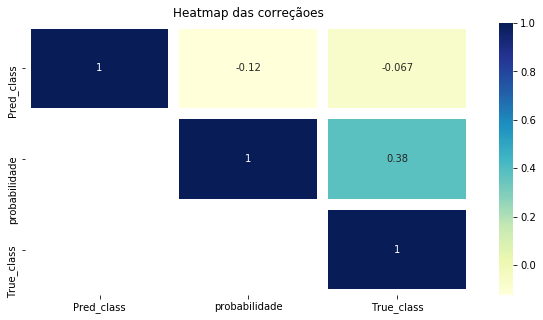

,Pred_class,probabilidade,True_class
Pred_class,1.000000,-0.123457,-0.067319
probabilidade,-0.123457,1.000000,0.381209
True_class,-0.067319,0.381209,1.000000


In [11]:
print("quantidade de dados ausentes: ", data['True_class'].isna().sum())

mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True
mask = mask == False

plt.figure(figsize=(10,5))
plt.title("Heatmap das correçãoes")
sns.heatmap(data.corr(), annot=True, linewidths=10, cmap="YlGnBu", mask=mask)
plt.show()
data.corr()

quantidade de dados ausentes:  0


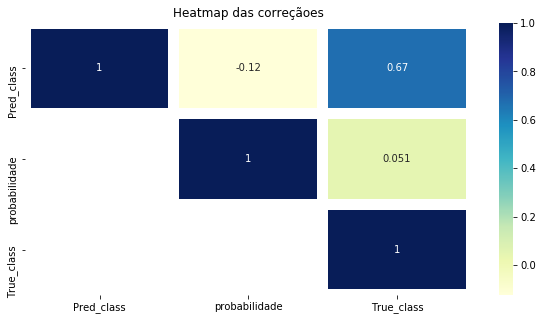

,Pred_class,probabilidade,True_class
Pred_class,1.000000,-0.123457,0.672541
probabilidade,-0.123457,1.000000,0.051251
True_class,0.672541,0.051251,1.000000


In [12]:
print("quantidade de dados ausentes: ", not_nan_data['True_class'].isna().sum())

mask = np.zeros_like(not_nan_data.corr())
mask[np.triu_indices_from(mask)] = True
mask = mask == False

plt.figure(figsize=(10,5))
plt.title("Heatmap das correçãoes")
sns.heatmap(not_nan_data.corr(), annot=True, linewidths=10, cmap="YlGnBu", mask=mask)
plt.show()
data.corr()

not_nan_data.corr()

Os dados sem preencher os dados ausentes True_class com valores da Pred_class nos indicam uma correlação entre probabildiade e True class de quase 0.4, um valor bem interessante e util. No entanto, após o preenchimento dos dados, tal valor cai para 0.05, uma correlação quase insignificante. Veremos mais a frente como os modelos se comportarão perante os dois dados

Vamos analisar mais um caso: E se ao inves de preenchermos os todos os dados ausentes com o valor da predição, classificassemos apenas aqueles com o status de aprovado? Vamos verificar

quantidade de dados ausentes:  43


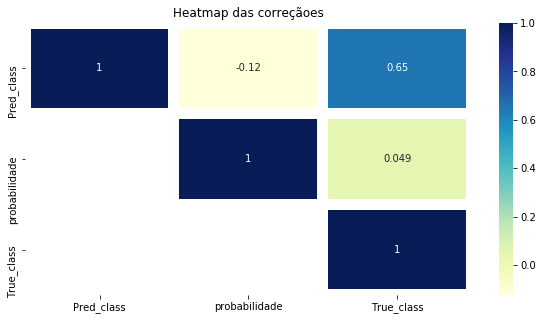

,Pred_class,probabilidade,True_class
Pred_class,1.000000,-0.123457,0.65449
probabilidade,-0.123457,1.000000,0.04903
True_class,0.654490,0.049030,1.00000


In [13]:
data_aux = data.copy()

data_aux['True_class'] = data.apply(
    lambda row: row['Pred_class'] if row['status'] == 'approved' and math.isnan(row['True_class']) else row['True_class'],
    axis=1
)

print("quantidade de dados ausentes: ", data_aux['True_class'].isna().sum())

mask = np.zeros_like(data_aux.corr())
mask[np.triu_indices_from(mask)] = True
mask = mask == False

plt.figure(figsize=(10,5))
plt.title("Heatmap das correçãoes")
sns.heatmap(data_aux.corr(), annot=True, linewidths=10, cmap="YlGnBu", mask=mask)
plt.show()
data.corr()

not_nan_data.corr()

data_aux.corr()

Muito interessante, a correlação foi ainda menor que a simples subistituição. Ou seja, não obtivemos um resultado bom pra considerarmos esses dados durante o modelo

### Correlação entre o status e clasificação do modelo

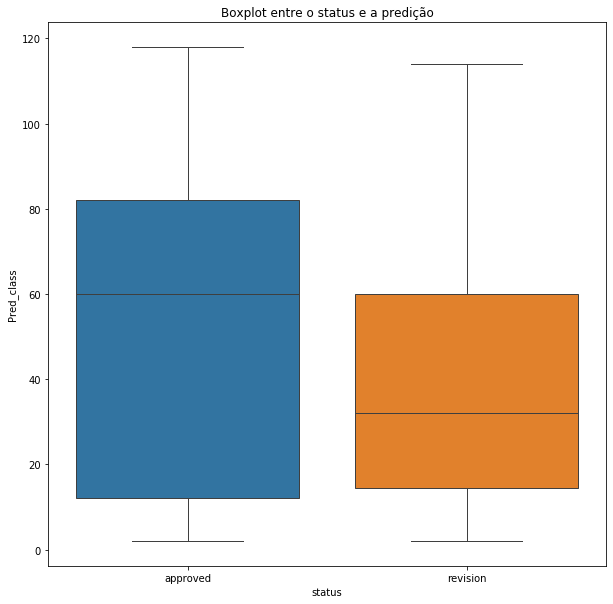

In [14]:
plt.figure(figsize=(10,10))
plt.title("Boxplot entre o status e a predição")
sns.boxplot(x="status", y="Pred_class", data=not_nan_data, linewidth=1);

É possivel inferir que, classificações de classes entre 60-80 possuem um grau de confiança muito maior, enquanto que nos dados entre 60-15, há a presença de informações que necessitam de revisão do mesmo. 

## Metricas de desempenho - Item 2

Para calcularmos as metricas precisamos de dados em que há a True_class, excluindo os com dados ausentes, pois as metricas são calculadas na forma f(true_class, predicted_class) -> $\mathbb{R}$

### Acurácia

Podemos calcular manualmente:

In [15]:
predicted_class = not_nan_data['Pred_class']
true_class = not_nan_data['True_class']

acertos = 0
for index in range(len(true_class)):
    if int(true_class[index]) == int(predicted_class[index]):
        acertos += 1
print("Acuracia: ", acertos/len(not_nan_data))

Acuracia:  0.71850699844479


Ou usando a biblioteca do scikit-learn

In [16]:
print("Acuracia: ", accuracy_score(predicted_class, true_class))

Acuracia:  0.71850699844479


### F1-Score

In [17]:
print("F1-Score: ", f1_score(predicted_class, true_class, average='micro'))

F1-Score:  0.7185069984447899


In [18]:
print("F1-Score: ", f1_score(predicted_class, true_class, average='macro'))

F1-Score:  0.6351511049464889


In [19]:
print("F1-Score: ", f1_score(predicted_class, true_class, average='weighted'))

F1-Score:  0.733533262185557


### Recall

In [20]:
print("Recall: ", recall_score(predicted_class, true_class, average='micro'))

Recall:  0.71850699844479


In [21]:
print("Recall: ", recall_score(predicted_class, true_class, average='macro'))

Recall:  0.6286648904994168


/home/andresacilotti/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
print("Recall: ", recall_score(predicted_class, true_class, average='weighted'))

Recall:  0.71850699844479


### Precision

In [23]:
print("Precision: ", precision_score(predicted_class, true_class, average='micro'))

Precision:  0.71850699844479


In [24]:
print("Precision: ", precision_score(predicted_class, true_class, average='macro'))

Precision:  0.6997739858971228


/home/andresacilotti/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
print("Precision: ", precision_score(predicted_class, true_class, average='weighted'))

Precision:  0.7961207918184912


## Modelo de classificação - Item 3

Podemos modelar esse problema da seguinte forma.

Nosso sistema precisa definir se os dados para revisão estão corretos ou não. Portanto, utilizaremos as seguintes variaveis:

Target -> Correto ou não (1 ou 0)
Features -> [Pred_class, probabilidade]

Primeiramente iremos separar os dados em aprovados e não aprovados. Além disso, iremos criar os targets, onde se o valor da Pred_class for igual ao da True_class então será considerado correto e recebera 1, caso contrario, receberá 0. Também iremos considerar avaliar o modelo aplicando as transformações na coluna da probabilidade, conforme destacado na analise exploratoria dos dados.

In [26]:
def _get_features(data):
    try:
        return data.loc[:, ['Pred_class', 'probabilidade']]
    except Exception as e:
        raise Exception("O dataframe deve conter as colunas Pred_class e probabilidade - {}".format(e))

def _filter_status(data, status):
    try:
        return data[data['status'] == status].reset_index(drop=True)
    except Exception as e:
        raise Exception("O dataframe deve conter a coluna status - {}".format(e))
        
def _preprocess_probability(data):
    try:
        normalized = preprocessing.normalize([data['probabilidade']])**(2/3)
        data['probabilidade'] = normalized.reshape(-1, 1)
        return data
    except Exception as e:
        raise Exception("O dataframe deve conter a coluna probabilidade - {}".format(e))


In [59]:
approved_data = _filter_status(not_nan_data, 'approved')

x_approved = _get_features(approved_data)

x_approved_preprocessed = _get_features(_preprocess_probability(approved_data))

y_approved = approved_data.apply(
    lambda row: 1 if row['Pred_class'] == row["True_class"] else 0,
    axis=1
)

Após isso podemos definir os dados de revisão que iremos classifica-los apos obter nosso modelo de aprendizado de maquina.

In [28]:
revision_data = _filter_status(not_nan_data, 'revision')

x_revision = _get_features(revision_data)

x_revision_preprocessed = _preprocess_probability(revision_data)

Antes de criar os modelos, precisamos escolher entre dividir uma parte fixa do nosso dataset de aprovados, ou realizar uma validação cruzada. A principio a validação cruzada apresenta alguns beneficios, como testar a generalização do modelo divindo em diferentes partes de testes e treinos

Testaremos com alguns modelos, como SVC, NB e XGB, além de diferentes metricas, como F1-Score, Acuracia, Recall e precision

In [55]:
scoring = [
    'accuracy',
    'f1_macro',
    'f1_micro',
    'recall_macro',
    'recall_micro',
    'precision_macro',
    'precision_micro'
]

Vale lembrar, que usaremos o metodo GridSearch, para otimizar os modelos, além disso, o gridsearchCV já vem uma validação cruzada do tipo K-Fold interna, que está definida como K=5

### SVC

#### Raw Data

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 531 out of 540 | elapsed:   11.8s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:   13.6s finished


SVC(C=10, coef0=0.001, degree=2, kernel='linear', random_state=42)


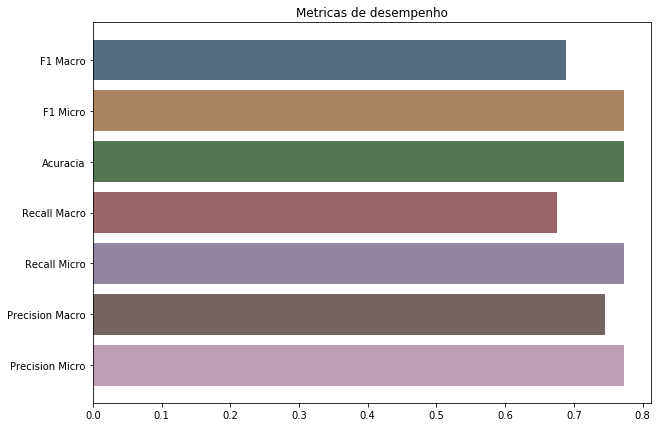

In [80]:
parameters = {
    'C': [0.001, 0.01, 1, 10],
    'kernel': ['linear','poly', 'sigmoid'],
    'degree': [2, 3, 4],
    'coef0': [0.001, 0, 1],
    'random_state': [42]
}

svc = SVC()
gs = GridSearchCV(svc, parameters, verbose=1, n_jobs=5, scoring=scoring, refit='f1_micro')

gs.fit(x_approved, y_approved)

metrics_labels = [
    'F1 Macro',
    "F1 Micro",
    "Acuracia",
    "Recall Macro",
    "Recall Micro",
    "Precision Macro",
    "Precision Micro"
]

metrics_data = [
    max(gs.cv_results_['mean_test_f1_macro']),
    max(gs.cv_results_['mean_test_f1_micro']),
    max(gs.cv_results_['mean_test_accuracy']),
    max(gs.cv_results_['mean_test_recall_macro']),
    max(gs.cv_results_['mean_test_recall_micro']),
    max(gs.cv_results_['mean_test_precision_macro']),
    max(gs.cv_results_['mean_test_precision_micro'])
]

plt.figure(figsize=(10,7))
plt.title("Metricas de desempenho")
sns.barplot(y=metrics_labels, x=metrics_data, orient='h', saturation=0.3)
plt.plot()

print(gs.best_estimator_)

#### Processed Data

SVC(C=10, coef0=0.001, degree=2, kernel='linear', random_state=42)


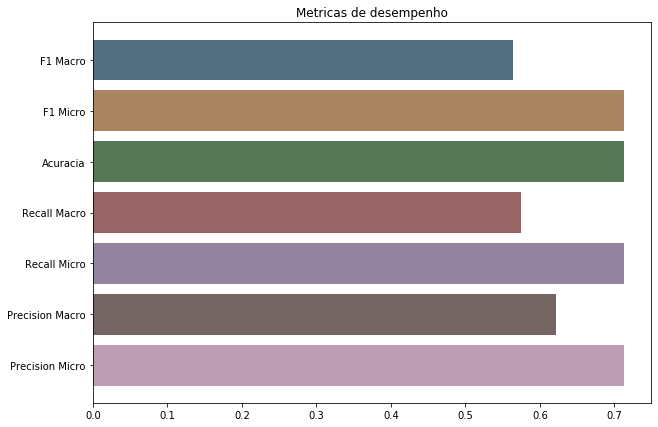

In [79]:
parameters = {
    'C': [0.001, 0.01, 1, 10],
    'kernel': ['linear','poly', 'sigmoid'],
    'degree': [2, 3, 4],
    'coef0': [0.001, 0, 1],
    'random_state': [42]
}

svc = SVC()
gs = GridSearchCV(svc, parameters, verbose=1, n_jobs=5, scoring=scoring, refit='f1_micro')

gs.fit(x_approved_preprocessed, y_approved)

metrics_labels = [
    'F1 Macro',
    "F1 Micro",
    "Acuracia",
    "Recall Macro",
    "Recall Micro",
    "Precision Macro",
    "Precision Micro"
]

metrics_data = [
    max(gs.cv_results_['mean_test_f1_macro']),
    max(gs.cv_results_['mean_test_f1_micro']),
    max(gs.cv_results_['mean_test_accuracy']),
    max(gs.cv_results_['mean_test_recall_macro']),
    max(gs.cv_results_['mean_test_recall_micro']),
    max(gs.cv_results_['mean_test_precision_macro']),
    max(gs.cv_results_['mean_test_precision_micro'])
]

plt.figure(figsize=(10,7))
plt.title("Metricas de desempenho")
sns.barplot(y=metrics_labels, x=metrics_data, orient='h', saturation=0.3)
plt.plot()

print(gs.best_estimator_)

### NB

#### Raw Data

MultinomialNB(alpha=1e-05)


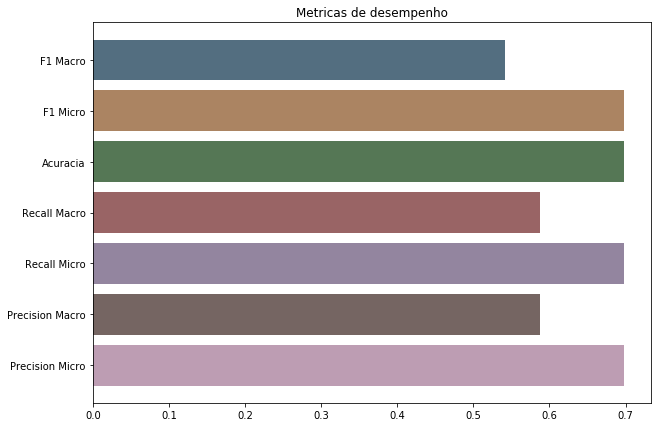

In [81]:
parameters = {
   'alpha':[0.00001, 0.1, 0.0001, 10, 1000, 1, 0.0000001, 500000, 10**(-10)],
    'fit_prior': [True, False]
}

nb = MultinomialNB()
gs = GridSearchCV(nb, parameters, n_jobs=5, scoring=scoring, refit='f1_micro')

gs.fit(x_approved, y_approved)

metrics_labels = [
    'F1 Macro',
    "F1 Micro",
    "Acuracia",
    "Recall Macro",
    "Recall Micro",
    "Precision Macro",
    "Precision Micro"
]

metrics_data = [
    max(gs.cv_results_['mean_test_f1_macro']),
    max(gs.cv_results_['mean_test_f1_micro']),
    max(gs.cv_results_['mean_test_accuracy']),
    max(gs.cv_results_['mean_test_recall_macro']),
    max(gs.cv_results_['mean_test_recall_micro']),
    max(gs.cv_results_['mean_test_precision_macro']),
    max(gs.cv_results_['mean_test_precision_micro'])
]

plt.figure(figsize=(10,7))
plt.title("Metricas de desempenho")
sns.barplot(y=metrics_labels, x=metrics_data, orient='h', saturation=0.3)
plt.plot()

print(gs.best_estimator_)

#### Processed Data

MultinomialNB(alpha=1e-05)


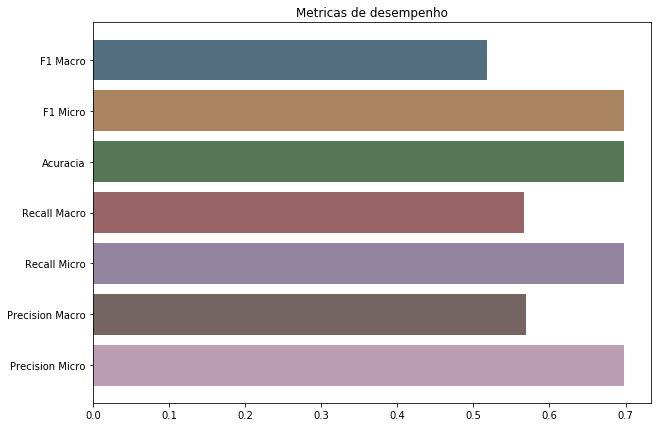

In [82]:
parameters = {
   'alpha':[0.00001, 0.1, 0.0001, 10, 1000, 1, 0.0000001, 500000, 10**(-10)],
    'fit_prior': [True, False]
}

nb = MultinomialNB()
gs = GridSearchCV(nb, parameters, n_jobs=5, scoring=scoring, refit='f1_micro')

gs.fit(x_approved_preprocessed, y_approved)

metrics_labels = [
    'F1 Macro',
    "F1 Micro",
    "Acuracia",
    "Recall Macro",
    "Recall Micro",
    "Precision Macro",
    "Precision Micro"
]

metrics_data = [
    max(gs.cv_results_['mean_test_f1_macro']),
    max(gs.cv_results_['mean_test_f1_micro']),
    max(gs.cv_results_['mean_test_accuracy']),
    max(gs.cv_results_['mean_test_recall_macro']),
    max(gs.cv_results_['mean_test_recall_micro']),
    max(gs.cv_results_['mean_test_precision_macro']),
    max(gs.cv_results_['mean_test_precision_micro'])
]

plt.figure(figsize=(10,7))
plt.title("Metricas de desempenho")
sns.barplot(y=metrics_labels, x=metrics_data, orient='h', saturation=0.3)
plt.plot()

print(gs.best_estimator_)

### XGB

#### Raw Data

XGBClassifier(max_depth=6, random_state=42, subsample=0.1)


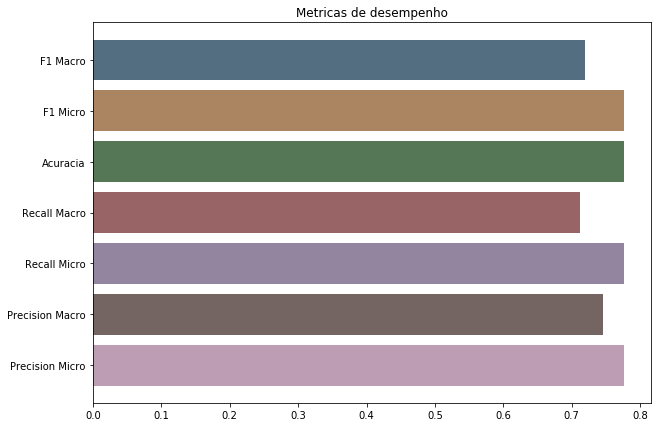

In [83]:
parameters = {
    'learning_rate': [0.3, 0.1, 0.15],
    'gamma': [0, 100],
    'max_depth': [6, 3, 10, 25],
    'subsample': [1, 0.5, 0.1],
    'scale_pos_weight': [0, 1],
    'random_state': [42]
}

_xgb = xgb.XGBClassifier()
gs = GridSearchCV(_xgb, parameters, n_jobs=5, scoring=scoring, refit='f1_micro')

gs.fit(x_approved, y_approved)

metrics_labels = [
    'F1 Macro',
    "F1 Micro",
    "Acuracia",
    "Recall Macro",
    "Recall Micro",
    "Precision Macro",
    "Precision Micro"
]

metrics_data = [
    max(gs.cv_results_['mean_test_f1_macro']),
    max(gs.cv_results_['mean_test_f1_micro']),
    max(gs.cv_results_['mean_test_accuracy']),
    max(gs.cv_results_['mean_test_recall_macro']),
    max(gs.cv_results_['mean_test_recall_micro']),
    max(gs.cv_results_['mean_test_precision_macro']),
    max(gs.cv_results_['mean_test_precision_micro'])
]

plt.figure(figsize=(10,7))
plt.title("Metricas de desempenho")
sns.barplot(y=metrics_labels, x=metrics_data, orient='h', saturation=0.3)
plt.plot()

print(gs.best_estimator_)

#### Processed Data

XGBClassifier(random_state=42, subsample=0.1)


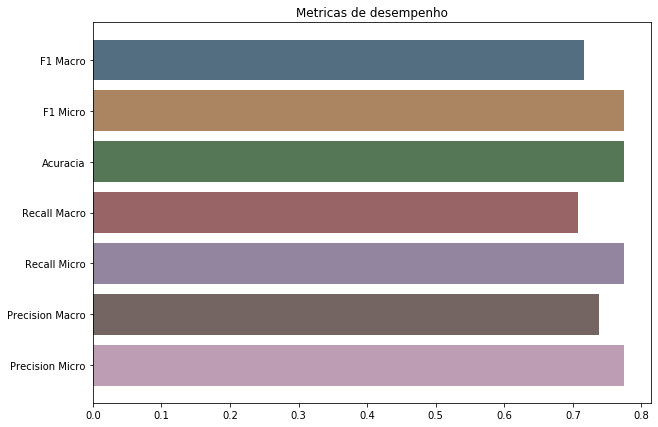

In [84]:
parameters = {
    'learning_rate': [0.3, 0.1, 0.15],
    'gamma': [0, 100],
    'max_depth': [6, 3, 10, 25],
    'subsample': [1, 0.5, 0.1],
    'scale_pos_weight': [0, 1],
    'random_state': [42]
}

_xgb = xgb.XGBClassifier()
gs = GridSearchCV(_xgb, parameters, n_jobs=5, scoring=scoring, refit='f1_micro')

gs.fit(x_approved_preprocessed, y_approved)

metrics_labels = [
    'F1 Macro',
    "F1 Micro",
    "Acuracia",
    "Recall Macro",
    "Recall Micro",
    "Precision Macro",
    "Precision Micro"
]

metrics_data = [
    max(gs.cv_results_['mean_test_f1_macro']),
    max(gs.cv_results_['mean_test_f1_micro']),
    max(gs.cv_results_['mean_test_accuracy']),
    max(gs.cv_results_['mean_test_recall_macro']),
    max(gs.cv_results_['mean_test_recall_micro']),
    max(gs.cv_results_['mean_test_precision_macro']),
    max(gs.cv_results_['mean_test_precision_micro'])
]

plt.figure(figsize=(10,7))
plt.title("Metricas de desempenho")
sns.barplot(y=metrics_labels, x=metrics_data, orient='h', saturation=0.3)
plt.plot()

print(gs.best_estimator_)

Podemos inferir que o melhor modelo foi o XGB, o qual obteve resultados semelhantes tanto para os dados processados quanto para os dados brutos. Portanto nosso classificador é o seguinte:

In [85]:
_xgb = xgb.XGBClassifier(random_state=42, subsample=0.1)

Para analisar as metricas, utilizaremos os dados do XGB treinado com dados brutos, sem processamento

In [91]:
gs = GridSearchCV(_xgb, parameters, n_jobs=5, scoring=scoring, refit='f1_micro')

gs.fit(x_approved, y_approved)

metrics_labels = {
    'F1 Macro': max(gs.cv_results_['mean_test_f1_macro']),
    "F1 Micro": max(gs.cv_results_['mean_test_f1_micro']),
    "Acuracia": max(gs.cv_results_['mean_test_accuracy']),
    "Recall Macro": max(gs.cv_results_['mean_test_recall_macro']),
    "Recall Micro": max(gs.cv_results_['mean_test_recall_micro']),
    "Precision Macro": max(gs.cv_results_['mean_test_precision_macro']),
    "Precision Micro": max(gs.cv_results_['mean_test_precision_micro'])
}


## Analise das Métricas - Item 4

Vamos comparar tres:

* F1-Score Macro
* Acuracia
* Recall Macro

In [93]:
print(metrics_labels['F1 Macro'])
print(metrics_labels['Acuracia'])
print(metrics_labels['Recall Macro'])

0.7200056643841849
0.7766666666666666
0.7115684100623859


Todas com resultados proximos, mas diferentes. Vamos entender o por que

### F1 - Score

O escore F é uma media harmonica entre a precisção calculada e a o recall. É uma boa metrica para datasets desbalanceados, pois a maedia harmonica garantirá a participação no calculo todas as classes. Um exemplo classico são os datasets de analise de credito, onde geralmente se tem 99% de class A e 1% class B, se o sistema tiver um overfiting em A, teremos uma acuracia de 99% e um F1-score de aproximadamente 50%.

### Acuracia

Uma das metricas mais simples, é basicamente a taxa de acerto pelo total de dados. É extremamente sensivel a classes desbalanceados, como exemplificado no caso do F1-Score.

### Recall

Define a quantidade de dados positivos de uma classe, em relação a quantidade total de dados naquela classe.